# [E-03] Face Detection : make a face filter
------------

[고양이 수염 이미지](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1) 로 스티커를 만들어서 얼굴 사진에 적용시켜보자.

## 01. 이미지 업로드

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

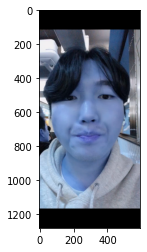

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/KakaoTalk_20220116_002750627.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

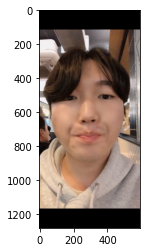

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

---
## 02. 얼굴 검출과 Landmark

In [4]:
detector_hog = dlib.get_frontal_face_detector()

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(40, 400) (502, 862)]]


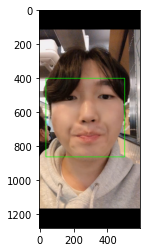

In [6]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


## Face landmarks가 찍히는 방식.
스티커를 어떤 좌표에 둘지 결정하기 위해 점들의 번호를 보면서 위치를 잡아야함.
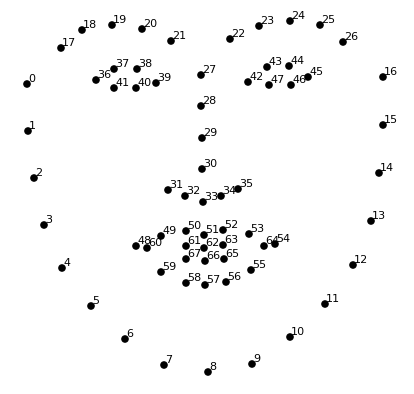

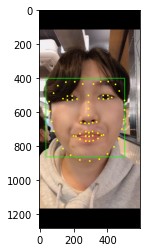

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

---
## 03. 스티커 적용 위치 정하기.

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(289, 618)
(x,y) : (289,387)
(w,h) : (463,463)


(463, 463, 3)


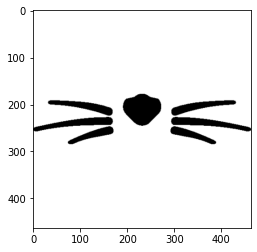

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

In [12]:
refined_x = x - w // 2 # x : left, y : top
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (58,387)


아래는 얼굴 사진을 넘어가서 스티커 이미지가 잘릴 경우에 적용해주는 코드 블럭.

In [13]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:] 
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (58,387)


### 왜 [:, -refined_x:]와 [-refined_y:, :]로 슬라이싱하는가?

[행 ,열]을 나타낸다고 생각했을 때 y축이 행을 세는 방향 x축이 열을 세는 방향이 된다.


---
## 04. 스티커 적용

In [14]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 흰색이 아닌 검은색 코와 수염 부분만 스티커로 사용하기 위해
# np.where를 통해 img_sticker 가 255 인 부분은 sticker_area를 사용하고
# 255가 아닌 부분을 img_sticker를 사용해서 img_show 에 다시 적용

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

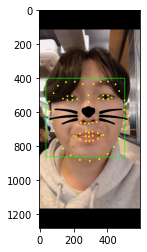

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

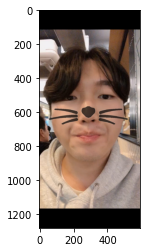

In [16]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(
    sticker_area, 0.3, 
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.7, 
    0
)
# cv2.addWeighted(src1, alpha, src2, beta, gamma)의 형태로 
# src1,2에 대한 가중치를 부여하여 두 사진을 합성시킵니다.

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


---
## 05. 다른 이미지에 적용
### : 다른 각도로 적용해보기
### 5-1-1 비스듬한 각도의 사진 불러오기

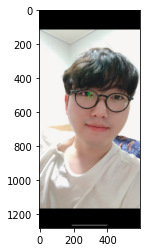

In [3]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/KakaoTalk_20220116_002750627_02.jpg'
img_bgr = cv2.imread(my_image_path)  
img_show = img_bgr.copy()   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


### 5-1-2 얼굴 검출 및 Landmark

rectangles[[(161, 418) (546, 804)]]
68


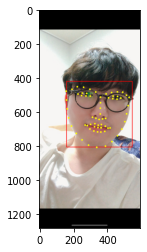

In [4]:
detector_hog = dlib.get_frontal_face_detector()   
dlib_rects = detector_hog(img_rgb, 1) 
print(dlib_rects)   # 얼굴영역 박스의 lefttop - rightbottom 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,0,255), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 5, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 5-1-3 스티커 적용

(359, 610)
(x,y) : (359,417)
(w,h) : (386,386)
(386, 386, 3)
(x,y) : (166,417)


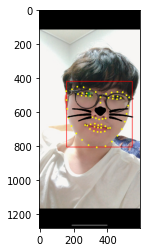

In [5]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

# 스티커 불러오기/리사이즈

refined_x = x - w // 2  # left
refined_y = y       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 5-1-4 문제점 및 해결방안
Landmark와 비교해보면 수염의 각도가 틀어진 것을 확인할 수가 있다.
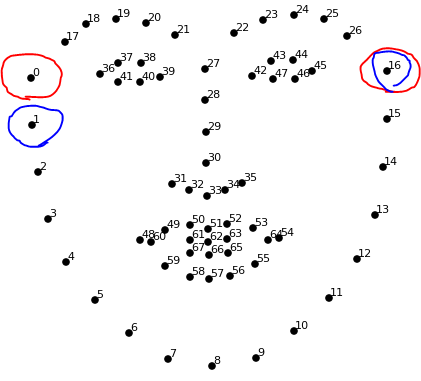
고양이 수염의 가장 윗쪽 양쪽 끝이 1과 16을 가르키고 있는데, 
기울어지지 않았다면 0과 16을 통해 그려지는 직선과 고양이 수염이 수평이 되어야 한다.
하나의 점을 기준으로 잡고 스티커를 적용하기 때문에 당연한 결과라고 생각한다.

- 해결방안

랜드마크의 점을 이용하여 얼굴의 기울어진 각을 구하고, 그 각을 이용해 스티커도 같은 각도로 돌려준다.
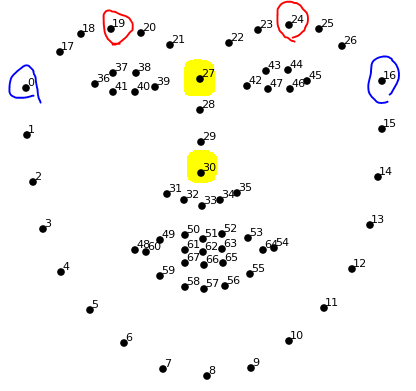
각을 구할 방법이 많은데, 빨간점(19, 24)를 선택하면 표정 또는 눈을 어떻게 떴는가에 따라 얼굴 각도와 관련이 없어질 수도 있을 것 같다. 파란점(0, 16) 관자놀이 광대 윗쪽 근처 부분인데 표정에 영향을 받지 않고 거의 움직이지 않는 부분이라 사용해도 적합해보인다. 하지만 y축 기준으로 조금의 회전에도 영향을 크게 받을 것 같다. 노란점(27,30) 표정이 변해도 코의 라인은 변하지 않기 때문에 적합해보이며, 얼굴의 y축 회전에 의해 가려질 일도 거의 없다. 27번과 30번 점을 기준으로 회전각을 구해보자.

In [6]:
# 비스듬한 얼굴의 각도를 구하자.
import math

tan = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
theta = np.arctan(tan)
rotate_angle = theta * 180/math.pi
rotate_angle

-0.5787255656077621

In [7]:
np.array(img_sticker.shape[:2]) / 2

array([193., 193.])

(386, 386, 3)


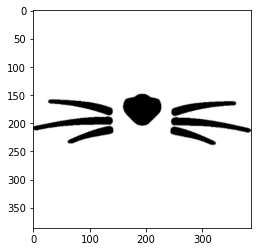

In [8]:
def rotate_image(image, angle):
  center = np.array(img_sticker.shape[:2]) / 2
  rotate_img = cv2.getRotationMatrix2D(center, angle, 1.0)
  result = cv2.warpAffine(image, rotate_img, image.shape[:2], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

In [9]:
tan = (landmark[16][1]-landmark[0][1])/(landmark[0][0]-landmark[16][0])
theta = np.arctan(tan)
rotate_angle = theta * 180/math.pi
rotate_angle

-5.725966300402285

(386, 386, 3)


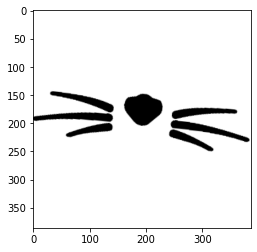

In [10]:
def rotate_image(image, angle):
  center = np.array(img_sticker.shape[:2]) / 2
  rotate_img = cv2.getRotationMatrix2D(center, angle, 1.0)
  result = cv2.warpAffine(image, rotate_img, image.shape[:2], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

(x,y) : (166,417)


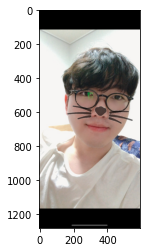

In [12]:
refined_x = x - w // 2  # left
refined_y = y       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

sticker_area = img_bgr[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]]
img_bgr[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = \
    np.where(img_rotate==255,sticker_area, cv2.addWeighted(img_rotate, 0.6, sticker_area, 0.4, 0)).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 5-1-5 결과
얼굴이 기울어진 각도에 맞게 수염이 잘 달린 것 같다.


### 5-2-1 x축 회전의 사진 불러오기

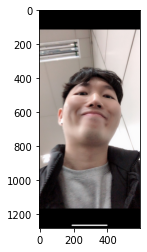

In [13]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/KakaoTalk_20220116_002750627_01.jpg'
img_bgr = cv2.imread(my_image_path)  
img_show = img_bgr.copy()   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 5-2-2 얼굴 검출 및 Landmark
- x축으로 과하게 회전된 사진의 경우 face detect 자체가 되지 않는다. 
- y축의 과한 회전도 같은 결과를 보일 것 같고, 더 나아가 밝기, 사진 자체의 과한 회전(90도 이상), 얼굴이 가려진 사진 등. 얼굴에 landmark가 찍히기 어려운 모든 경우에 아래와 같은 에러가 뜬다.

In [14]:
detector_hog = dlib.get_frontal_face_detector()   
dlib_rects = detector_hog(img_rgb, 1) 
print(dlib_rects)   # 얼굴영역 박스의 lefttop - rightbottom 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,0,255), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 5, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

rectangles[]


IndexError: list index out of range

## 06. 회고

- 더욱 자연스럽고 다양한 스티커에 적용할 수 있도록 sticker area를 잡아주면 그 안에 sticker이미지를 구겨 넣어주는 모듈 또는 문법이 있는지, 찾아봐야 할 것 같다.
- 불친절한 사진들에도 인식의 임계값이 높은, 문제가 될 수 있는 다양한 얼굴 이미지들에 대해서 landmark가 잘 적용될 만한 방법이 있는지 찾아볼 필요가 있다.
- 추후에 동영상 또는 실시간 캠에 대해서 적용할 수 있는 방식에 대해 공부하고 싶다.

노드가 밀리면서 이번 익스에 시간을 많이 투자하지 못한 것이 아쉽다.
이와 관련된 프로젝트도 하나 진행하려고 계획해두었기 때문에 저장해둔 여러 논문과 자료들을 읽어보고 더욱 성능이 좋은 face detection과 자연스러운 스티커 적용 등에 대해 공부할 예정이다. 

